###### <font color="#483D8B">
<h1  align="center">Ensemble Learning Methods using H2O</h1>
<h3 align="center"> Ansh Sikka</h3>
<h3 align="center"> 03/12/2018</h3>

## Overview

### Goals
* Improve Model Performance with Ensemble Learning
* Use a special boosting algorithm that improves model performance and reduces bias

### Skills
* Implement xgboost into model

In [3]:
import xgboost as xgb
import pandas as pd
import h2o
from h2o.estimators import H2ORandomForestEstimator
from sklearn.metrics import accuracy_score

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,15 days 5 hours 35 mins
H2O cluster timezone:,America/Chicago
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.2
H2O cluster version age:,1 year and 19 days !!!
H2O cluster name:,H2O_from_python_anshikka_b6rz2z
H2O cluster total nodes:,1
H2O cluster free memory:,3.223 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


## Data 
We will be using the agaricus dataset. 

For our classifier without boosting, we will be using the CSV from https://www.kaggle.com/uciml/mushroom-classification

* C1: classedible=e, poisonous=p
* C2: cap-shapebell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s
* C3: cap-surfacefibrous=f,grooves=g,scaly=y,smooth=s
* C4: cap-colorbrown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y
* C5: bruisesbruises=t,no=f
* C6: odoralmond=a,anise=l,creosote=c,fishy=y,foul=f,musty=m,none=n,pungent=p,spicy=s
* C7: gill-attachmentattached=a, descending=d, free=f, notched=n
* C8: gill-spacingclose=c,crowded=w,distant=d
* C9: gill-sizebroad=b,narrow=n
* C10: gill-colorblack=k,brown=n,buff=b,chocolate=h,gray=g, green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y
* C11: stalk-shape
* C12: stalk-root
* C13: stalk-surface-above-ring
* C14: stalk-surface-below-ring
* C15: stalk-color-above-ring
* C16: stalk-color-below-ring
* C17: veil-type
* C18: veil-color
* C19: ring-number
* C20: ring-type
* C21: spore-print-color
* C22: population
* C23: habitat


For our classifier with XGBoost, we will be using the dataset form 
https://github.com/dmlc/xgboost/blob/master/demo/data/agaricus.txt.test

The feature map is described here: https://github.com/dmlc/xgboost/blob/master/demo/data/featmap.txt#L30

In [4]:
mushroom_data = h2o.import_file('mushrooms.csv')

Parse progress: |█████████████████████████████████████████████████████████| 100%


## Exploratory Data Analysis

In [5]:
mushroom_data.col_names

['C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'C15',
 'C16',
 'C17',
 'C18',
 'C19',
 'C20',
 'C21',
 'C22',
 'C23']

In [6]:
mushroom_data.describe()

Rows:8125
Cols:23




,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23
type,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum
mins,,,,,,,,,,,,,,,,,,,,,,,
mean,,,,,,,,,,,,,,,,,,,,,,,
maxs,,,,,,,,,,,,,,,,,,,,,,,
sigma,,,,,,,,,,,,,,,,,,,,,,,
zeros,,,,,,,,,,,,,,,,,,,,,,,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
1,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
2,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g


As we can see, the data is all shown as letters. We have to find some way to encode this to numerical values to fit our model. 

In [7]:
mushroom_data = mushroom_data.asnumeric()

In [8]:
mushroom_data.describe()

Rows:8125
Cols:23




,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23
type,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int
mins,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,1.4818461538461538,4.2916923076923075,2.827323076923077,5.478153846153846,1.415384615384616,4.318276923076923,0.974276923076923,0.3230769230769231,0.6184615384615385,5.4932923076923075,1.1344,1.1102769230769232,1.5782153846153844,1.6387692307692308,6.366892307692308,6.337353846153846,0.00012307692307692307,2.9417846153846154,1.1433846153846154,2.292307692307692,3.902769230769231,4.505476923076923,1.8567384615384614
maxs,2.0,6.0,4.0,10.0,2.0,9.0,2.0,2.0,2.0,12.0,2.0,5.0,4.0,4.0,9.0,9.0,1.0,4.0,3.0,5.0,9.0,6.0,7.0
sigma,0.49994735169545135,1.7326437348774268,1.2301968653587674,2.5945292477046804,0.49306826357031086,2.3742872126615513,0.15909327214603255,0.7360154509805564,0.9243432715485954,3.9251503251698336,0.990926039895801,1.0619181221237886,0.6306960160664118,0.767122589290631,2.2734984989575726,2.280229747004696,0.011094003924504582,0.3890209344360002,0.5285959732993591,1.80181159284112,2.8231822317862196,1.5539298459519368,2.150116034598863
zeros,1,452,1,168,1,400,210,6812,5612,1728,3516,2480,552,600,432,432,8124,96,36,2776,48,384,3148
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0.0,2.0,0.0,2.0,0.0,6.0,2.0,1.0,1.0,3.0,1.0,5.0,3.0,3.0,7.0,7.0,1.0,2.0,2.0,5.0,6.0,3.0,2.0
1,2.0,6.0,3.0,5.0,2.0,7.0,1.0,0.0,2.0,5.0,0.0,3.0,2.0,2.0,8.0,8.0,0.0,3.0,1.0,4.0,2.0,4.0,6.0
2,1.0,6.0,3.0,10.0,2.0,0.0,1.0,0.0,0.0,5.0,0.0,2.0,2.0,2.0,8.0,8.0,0.0,3.0,1.0,4.0,3.0,2.0,1.0


Now we see that we are getting information about this datset! We can see that as we go down within the columns, we see that values are missing. Let's fill these in. 

In [9]:
mushroom_data = mushroom_data.fillna()

In [10]:
mushroom_data.describe()

Rows:8125
Cols:23




,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23
type,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int
mins,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,1.4818461538461538,4.2916923076923075,2.827323076923077,5.478153846153846,1.415384615384616,4.318276923076923,0.974276923076923,0.3230769230769231,0.6184615384615385,5.4932923076923075,1.1344,1.1102769230769232,1.5782153846153844,1.6387692307692308,6.366892307692308,6.337353846153846,0.00012307692307692307,2.9417846153846154,1.1433846153846154,2.292307692307692,3.902769230769231,4.505476923076923,1.8567384615384614
maxs,2.0,6.0,4.0,10.0,2.0,9.0,2.0,2.0,2.0,12.0,2.0,5.0,4.0,4.0,9.0,9.0,1.0,4.0,3.0,5.0,9.0,6.0,7.0
sigma,0.49994735169545135,1.7326437348774268,1.2301968653587674,2.5945292477046804,0.49306826357031086,2.3742872126615513,0.15909327214603255,0.7360154509805564,0.9243432715485954,3.9251503251698336,0.990926039895801,1.0619181221237886,0.6306960160664118,0.767122589290631,2.2734984989575726,2.280229747004696,0.011094003924504582,0.3890209344360002,0.5285959732993591,1.80181159284112,2.8231822317862196,1.5539298459519368,2.150116034598863
zeros,1,452,1,168,1,400,210,6812,5612,1728,3516,2480,552,600,432,432,8124,96,36,2776,48,384,3148
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0.0,2.0,0.0,2.0,0.0,6.0,2.0,1.0,1.0,3.0,1.0,5.0,3.0,3.0,7.0,7.0,1.0,2.0,2.0,5.0,6.0,3.0,2.0
1,2.0,6.0,3.0,5.0,2.0,7.0,1.0,0.0,2.0,5.0,0.0,3.0,2.0,2.0,8.0,8.0,0.0,3.0,1.0,4.0,2.0,4.0,6.0
2,1.0,6.0,3.0,10.0,2.0,0.0,1.0,0.0,0.0,5.0,0.0,2.0,2.0,2.0,8.0,8.0,0.0,3.0,1.0,4.0,3.0,2.0,1.0


There! It looks like our data is all cleaned up! Let's fit our models. 

## Models

### Random Forest Classifier
To classify this dataset, we will use a random forest classifier since it is the most effective in reducing.

In [15]:
training_columns = ['C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'C15',
 'C16',
 'C17',
 'C18',
 'C19',
 'C20',
 'C21',
 'C22',
 'C23']
response_column = 'C1'

In [16]:
train, test = mushroom_data.split_frame(ratios=[0.8])


In [17]:
model = H2ORandomForestEstimator(binomial_double_trees=False, seed=1234)

model.train(x=training_columns, y = response_column, training_frame = train, validation_frame = test)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [20]:
performance = model.model_performance(test_data=test)
print(model)
print(performance)
print('Model Type:', model.type)
print('R2', model.r2(valid = True))
print(model._model_json['output']['variable_importances'].as_data_frame)

Overfitting if: training loss >> validation loss
Underfitting if: training loss << validation loss

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1552239155776_7


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 1.0568919101293697e-05
RMSE: 0.0032509874040502983
MAE: 0.00015109927239650883
RMSLE: 0.001340000569952506
Mean Residual Deviance: 1.0568919101293697e-05

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 0.0012515662650602409
RMSE: 0.03537748245791723
MAE: 0.000963855421686747
RMSLE: 0.021901641223349647
Mean Residual Deviance: 0.0012515662650602409
Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2019-03-25 18:09:01,0.001 sec,0.0,nan,nan,nan,nan,nan,nan
,2019-03-25 18:09:01,0.016 sec,1.0,0.0291979,0.0008525,0.0008525,0.0245440,0.0006024,0.0006024
,2019-03-25 18:09:01,0.025 sec,2.0,0.0179814,0.0003880,0.0003233,0.0245440,0.0006024,0.0006024
,2019-03-25 18:09:01,0.032 sec,3.0,0.0101264,0.0002051,0.0001025,0.0245440,0.0006024,0.0006024
,2019-03-25 18:09:01,0.039 sec,4.0,0.0081572,0.0001536,0.0000665,0.0306800,0.0007530,0.0009413
---,---,---,---,---,---,---,---,---,---
,2019-03-25 18:09:02,0.333 sec,46.0,0.0035527,0.0001649,0.0000126,0.0357887,0.0009822,0.0012808
,2019-03-25 18:09:02,0.342 sec,47.0,0.0034357,0.0001599,0.0000118,0.0355489,0.0009741,0.0012637
,2019-03-25 18:09:02,0.351 sec,48.0,0.0034018,0.0001583,0.0000116,0.0358299,0.0009789,0.0012838
,2019-03-25 18:09:02,0.361 sec,49.0,0.0033281,0.0001550,0.0000111,0.0355991,0.0009712,0.0012673



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
C10,12272.4550781,1.0,0.2047594
C6,8361.2763672,0.6813043,0.1395034
C9,7553.1147461,0.6154526,0.1260197
C21,7441.625,0.6063681,0.1241596
C20,5244.2773438,0.4273210,0.0874980
---,---,---,---
C3,442.3371887,0.0360431,0.0073802
C4,333.4078674,0.0271672,0.0055627
C18,103.2932587,0.0084167,0.0017234
C2,81.2456055,0.0066202,0.0013555



See the whole table with table.as_data_frame()


ModelMetricsRegression: drf
** Reported on test data. **

MSE: 0.0012515662650602409
RMSE: 0.03537748245791723
MAE: 0.000963855421686747
RMSLE: 0.021901641223349647
Mean Residual Deviance: 0.0012515662650602409

Model Type: regressor
R2 0.9949950717183972
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
C10,12272.4550781,1.0,0.2047594
C6,8361.2763672,0.6813043,0.1395034
C9,7553.1147461,0.6154526,0.1260197
C21,7441.625,0.6063681,0.1241596
C20,5244.2773438,0.4273210,0.0874980
---,---,---,---
C3,442.3371887,0.0360431,0.0073802
C4,333.4078674,0.0271672,0.0055627
C18,103.2932587,0.0084167,0.0017234
C2,81.2456055,0.0066202,0.0013555



See the whole table with table.as_data_frame()
<bound method H2OTwoDimTable.as_data_frame of >


#### Interpretation
From this result, we can see that this model was fairly well-fitted. We see that the most important variable is C10, the gill color. This means that color is one of the most important characteristics for prediction. The mean-squared-error is very low, meaning that there was low error in predicting the test results. The R-squared score was also very close to 1, meaning that the model explains all the variablility of the response data around its mean. Let's try to reduce variance using boosint!

### Boosting Classifier
We will try our best to reduce variance and overfitting by using boosting. We will use a gradient-descent based boosting algorithm called xgboost.

Let's read our data in first with the dataset that is already converted for XGBoost's model. 

In [155]:
dtrain = xgb.DMatrix('agaricus.txt.train')
dtest = xgb.DMatrix('agaricus.txt.test')
from sklearn.datasets import load_svmlight_file
test_data = load_svmlight_file('agaricus.txt.test')[1]
print(test_data)


[23:16:57] 6513x127 matrix with 143286 entries loaded from agaricus.txt.train
[23:16:57] 1611x127 matrix with 35442 entries loaded from agaricus.txt.test
[0. 1. 0. ... 1. 0. 1.]


In [132]:
param = {'max_depth': 2, 'eta': 1, 'silent': 1, 'objective': 'binary:logistic'}
num_round = 2

In [141]:
watchlist = [(dtest,'eval'), (dtrain,'train')]

evals_result = {}
xg_boost_model = xgb.train(param, dtrain, num_round, watchlist, evals_result=evals_result)
preds = xg_boost_model.predict(dtest)

[0]	eval-error:0.042831	train-error:0.046522
[1]	eval-error:0.021726	train-error:0.022263


In [149]:
predictions = [round(prediction) for prediction in preds]

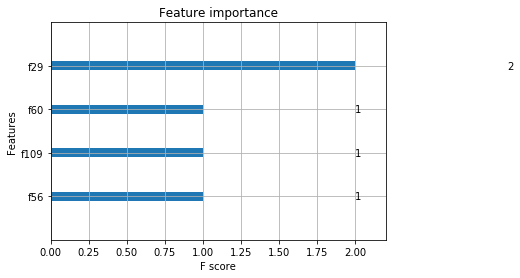

In [143]:
xgb.plot_importance(xg_boost_model)

In [151]:
print(dtest)

In [156]:
from sklearn.metrics import r2_score
r2_score(test_data, predictions)

0.9129807395518242

#### Interpretation
We see that this R^2 is a little lower. Why is this? Well, this time we are boosting and reducing variance, so the model will inheritly not overfit the data. This R^2 is still really high based on the data. However, there might be a little more bias this time in the data, as boosting does NOT target bias. For the feature importance, f29 is the odor, which is also a big characteristic in mushrooms. This feature importance graph doesn't consider gill color. RandomForest model probably assumed that the color is a major deciding factor when splitting decisions. However, it probably only is for THAT dataset. This one will generalize the features and look at it by reducing overfitting overall. 

### Conclusion

What I learned:
* RandomForest Classification Review (Using H2O)
* XGBoost
    * XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and      portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples. (See https://xgboost.readthedocs.io/en/latest/)

As we can see, the random forest classifier DID have a higher R^2 score. However, we didn't apply any variance reduction technique to the model. The data could have been a little more overfit and more specific to the dataset we trained. This model uses gradient descent algorithm to build smaller trees and essentially limits all of the factors that are increasing variance/covariance. This will reduce the R^2 score, but will also be more general to external datasets. 